In [1]:
# Core scverse libraries
from __future__ import annotations

import anndata as ad

# Data retrieval
import pooch
import matplotlib.pyplot as plt
import scanpy as sc
import numpy as np
import pandas as pd
import scrublet as scr
import muon as mu
# Import a module with ATAC-seq-related functions
from muon import atac as ac
%matplotlib inline

/mnt/sds-hd/sd25j001/miniconda3/envs/scRNAseq_env/lib/python3.14/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/mnt/sds-hd/sd25j001/miniconda3/envs/scRNAseq_env/lib/python3.14/site-packages/muon/_core/preproc.py:31: FutureWarning: `__version__` is deprecated, use `importlib.metadata.version('scanpy')` instead
  if Version(scanpy.__version__) < Version("1.10"):


In [2]:
#sc.settings.set_figure_params(dpi=50, facecolor="white")

## Read data
The dataset used:
https://www.10xgenomics.com/datasets/pbm-cs-of-a-healthy-donor-v-1-1-1-standard-3-1-0

The data is an mtx directory with an mtx file (i.e. count matrix), two tsv files with barcodes (i.e. cell indices) and features (i.e. gene symbols). Scanpy unpacks the files (if the files are in gz archive format) and creates an anndata object with the read_10x_mtx function.

In [2]:
#!/mnt/sds-hd/sd25j001/miniconda3/envs/scRNAseq_env/bin/wget https://cf.10xgenomics.com/samples/cell-vdj/3.1.0/vdj_v1_hs_pbmc3/vdj_v1_hs_pbmc3_filtered_feature_bc_matrix.tar.gz
#!/mnt/sds-hd/sd25j001/miniconda3/envs/scRNAseq_env/bin/tar -xvf vdj_v1_hs_pbmc3_filtered_feature_bc_matrix.tar.gz
!/mnt/sds-hd/sd25j001/miniconda3/envs/scRNAseq_env/bin/wget https://cf.10xgenomics.com/samples/cell-arc/2.0.0/pbmc_granulocyte_sorted_10k/pbmc_granulocyte_sorted_10k_filtered_feature_bc_matrix.tar.gz
!/mnt/sds-hd/sd25j001/miniconda3/envs/scRNAseq_env/bin/tar -xvf pbmc_granulocyte_sorted_10k_filtered_feature_bc_matrix.tar.gz
print("Data downloaded")

--2026-01-07 10:56:24--  https://cf.10xgenomics.com/samples/cell-arc/2.0.0/pbmc_granulocyte_sorted_10k/pbmc_granulocyte_sorted_10k_filtered_feature_bc_matrix.tar.gz
Resolving cf.10xgenomics.com (cf.10xgenomics.com)... 104.18.0.173, 104.18.1.173, 2606:4700::6812:1ad, ...
Connecting to cf.10xgenomics.com (cf.10xgenomics.com)|104.18.0.173|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 474035142 (452M) [application/x-tar]
Saving to: ‘pbmc_granulocyte_sorted_10k_filtered_feature_bc_matrix.tar.gz.1’

pbmc_granulocyte_so 100%[===================>] 452.07M  99.4MB/s    in 4.4s    

2026-01-07 10:56:29 (103 MB/s) - ‘pbmc_granulocyte_sorted_10k_filtered_feature_bc_matrix.tar.gz.1’ saved [474035142/474035142]

filtered_feature_bc_matrix/
filtered_feature_bc_matrix/matrix.mtx.gz
filtered_feature_bc_matrix/features.tsv.gz
filtered_feature_bc_matrix/barcodes.tsv.gz
Data downloaded


In [3]:
file_path_raw = './filtered_feature_bc_matrix/'
#adata = sc.read_10x_mtx(path=file_path_raw)
mdata = mu.read_10x_mtx(path=file_path_raw)
mdata.var_names_make_unique()
mdata

/mnt/sds-hd/sd25j001/miniconda3/envs/scRNAseq_env/lib/python3.14/site-packages/mudata/_core/mudata.py:1598: FutureWarning: From 0.4 .update() will not pull obs/var columns from individual modalities by default anymore. Set mudata.set_options(pull_on_update=False) to adopt the new behaviour, which will become the default. Use new pull_obs/pull_var and push_obs/push_var methods for more flexibility.
  self._update_attr("var", axis=0, join_common=join_common)
/mnt/sds-hd/sd25j001/miniconda3/envs/scRNAseq_env/lib/python3.14/site-packages/mudata/_core/mudata.py:1461: FutureWarning: From 0.4 .update() will not pull obs/var columns from individual modalities by default anymore. Set mudata.set_options(pull_on_update=False) to adopt the new behaviour, which will become the default. Use new pull_obs/pull_var and push_obs/push_var methods for more flexibility.
  self._update_attr("obs", axis=1, join_common=join_common)


MuData object with n_obs × n_vars = 11898 × 180488
  var:	'gene_ids', 'feature_types'
  2 modalities
    rna:	11898 x 36601
      var:	'gene_ids', 'feature_types'
    atac:	11898 x 143887
      var:	'gene_ids', 'feature_types'

Check the size of the data

In [4]:
print('Total number of observations: {:d}'.format(mdata.n_obs))

Total number of observations: 11898


## Quality control
Data quality control can be split into cell QC and gene QC. Typical quality measures for assessing the quality of a cell include the number of molecule counts (UMIs), the number of expressed genes, and the fraction of counts that are mitochondrial. A high fraction of mitochondrial reads being picked up can indicate cell stress, as there is a low proportion of nuclear mRNA in the cell. It should be noted that high mitochondrial RNA fractions can also be biological signals indicating elevated respiration.

We start with calculating the QC covariates:
* total number of counts per cell
* number of expressed genes per cell
* fraction of mitochondrial reads per cell

In [5]:
# Quality control - calculate QC covariates
rna = mdata.mod['rna']
rna.layers["counts"] = rna.X.copy()
rna.var['mt'] = rna.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(rna, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)


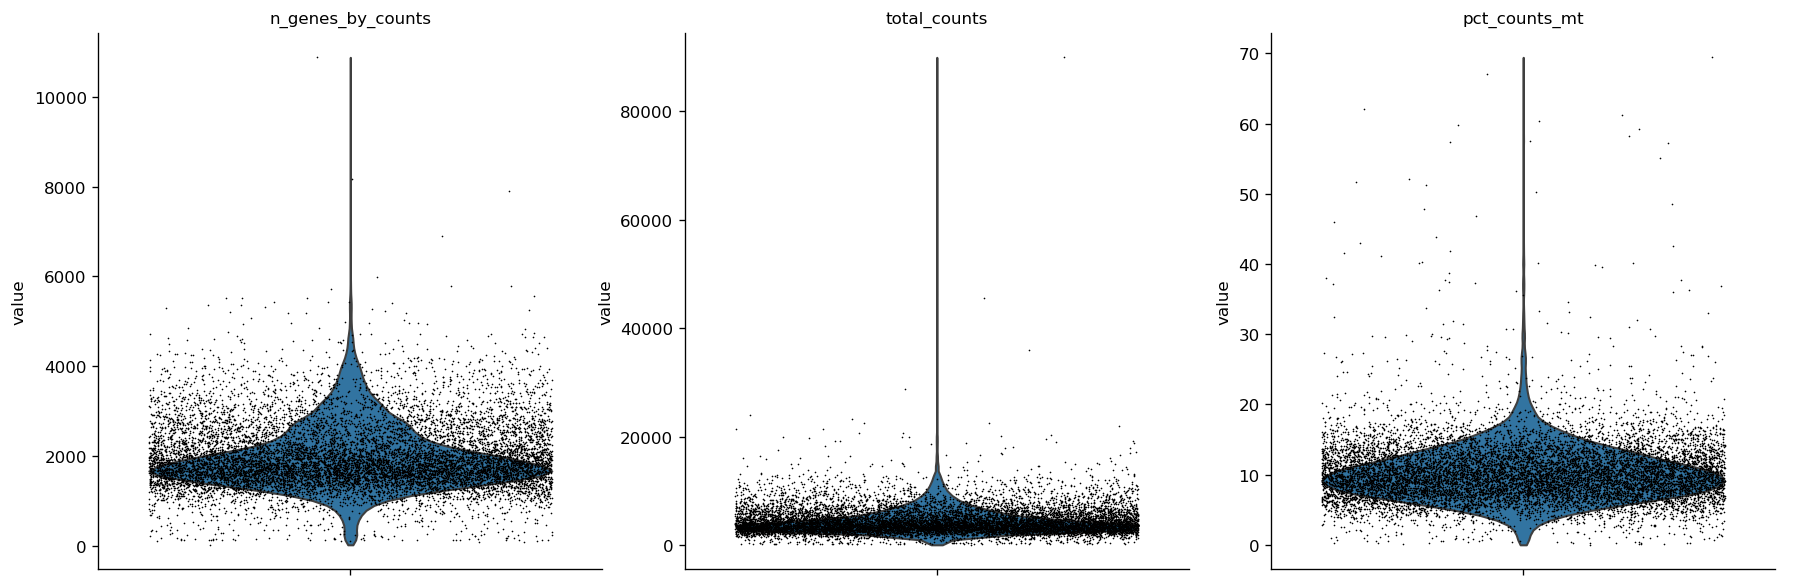

In [9]:
plt.rcParams["figure.figsize"] = (12, 4)   # width, height in inches
plt.rcParams["figure.dpi"] = 120
sc.pl.violin(rna, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True)

Filter your cells according for the total number of counts, number of expressed genes and fraction of mitochondrial reads. Check the number of remaining cells after each filtering step.

In [11]:
mu.pp.filter_var(rna, 'n_cells_by_counts', lambda x: x >= 3)
# This is analogous to
#   sc.pp.filter_genes(rna, min_cells=3)
# but does in-place filtering and avoids copying the object
# Filter cells according to identified QC thresholds:
mu.pp.filter_obs(rna, 'n_genes_by_counts', lambda x: (x >= 200) & (x < 5000))
# This is analogous to
#   sc.pp.filter_cells(rna, min_genes=200)
#   rna = rna[rna.obs.n_genes_by_counts < 5000, :]
# but does in-place filtering avoiding copying the object

mu.pp.filter_obs(rna, 'total_counts', lambda x: x < 15000)
mu.pp.filter_obs(rna, 'pct_counts_mt', lambda x: x < 20)

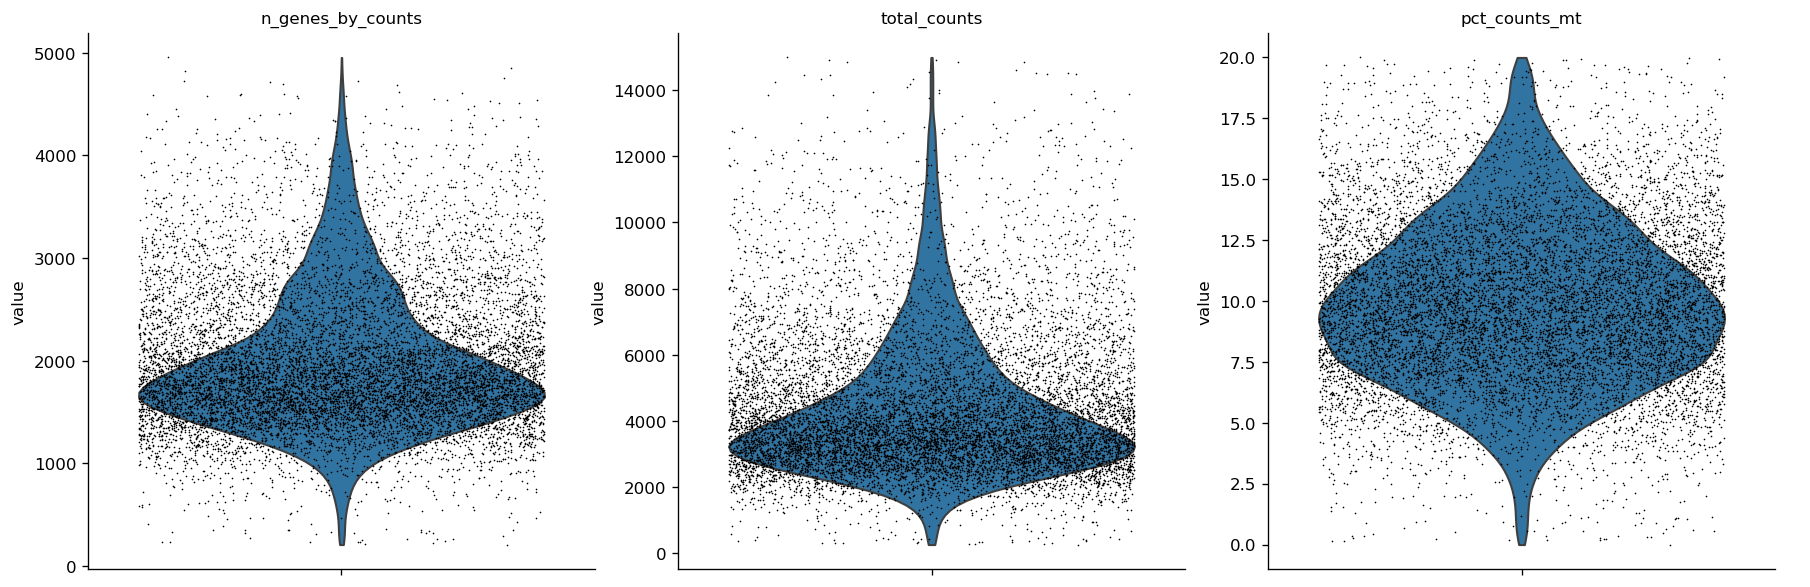

In [12]:
sc.pl.violin(rna, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True)

# Doublet score
Let us estimate the amount of doublets in the dataset.

In [15]:
rna.obs['doublet_score']= np.zeros(rna.shape[0])
rna.obs['doublet'] = np.zeros(rna.shape[0])

In [16]:
# filtering/preprocessing parameters:
min_counts = 2
min_cells = 3
vscore_percentile = 85
n_pc = 50

# doublet detector parameters:
expected_doublet_rate = 0.02 
sim_doublet_ratio = 3
n_neighbors = 15



scrub = scr.Scrublet(counts_matrix = rna.X,  
                     n_neighbors = n_neighbors,
                     sim_doublet_ratio = sim_doublet_ratio,
                     expected_doublet_rate = expected_doublet_rate)

doublet_scores, predicted_doublets = scrub.scrub_doublets( 
                    min_counts = min_counts, 
                    min_cells = min_cells, 
                    n_prin_comps = n_pc,
                    use_approx_neighbors = True, 
                    get_doublet_neighbor_parents = False)

rna.obs['doublet_score'] = doublet_scores
rna.obs['doublet'] = predicted_doublets

Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.15
Detected doublet rate = 2.8%
Estimated detectable doublet fraction = 27.0%
Overall doublet rate:
	Expected   = 2.0%
	Estimated  = 10.3%
Elapsed time: 11.1 seconds


## filtering doublets
Scrublet proposed a different threshold than we would choose based upon the histogram plot of the doublet scores.

In [17]:
thr = 0.05
ix_filt = rna.obs['doublet_score']<=thr

rna = rna[ix_filt]#.copy()
print('Number of cells after doublet filter: {:d}'.format(rna.n_obs))

Number of cells after doublet filter: 10138


## Normalization

So far, our dataset is a count matrix. Here, every count corresponds to an mRNA molecule captured in the scRNA-seq experiment. As not all mRNA molecules in a cell are captured, there is a variability in the total number of counts detected between cells that results from both the number of molecules that were in the cells, and the sampling. 

Several methods for normalization for scRNA-seq data have been proposed. Here, we normalize each cell by total counts over all genes, so that every cell has the same total count after normalization.

In [23]:
sc.pp.normalize_total(rna, target_sum=1e4)
sc.pp.log1p(rna)


/mnt/sds-hd/sd25j001/miniconda3/envs/scRNAseq_env/lib/python3.14/site-packages/scanpy/preprocessing/_normalization.py:269: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


#Feature selection
We will label highly variable genes that we’ll use for downstream analysis.

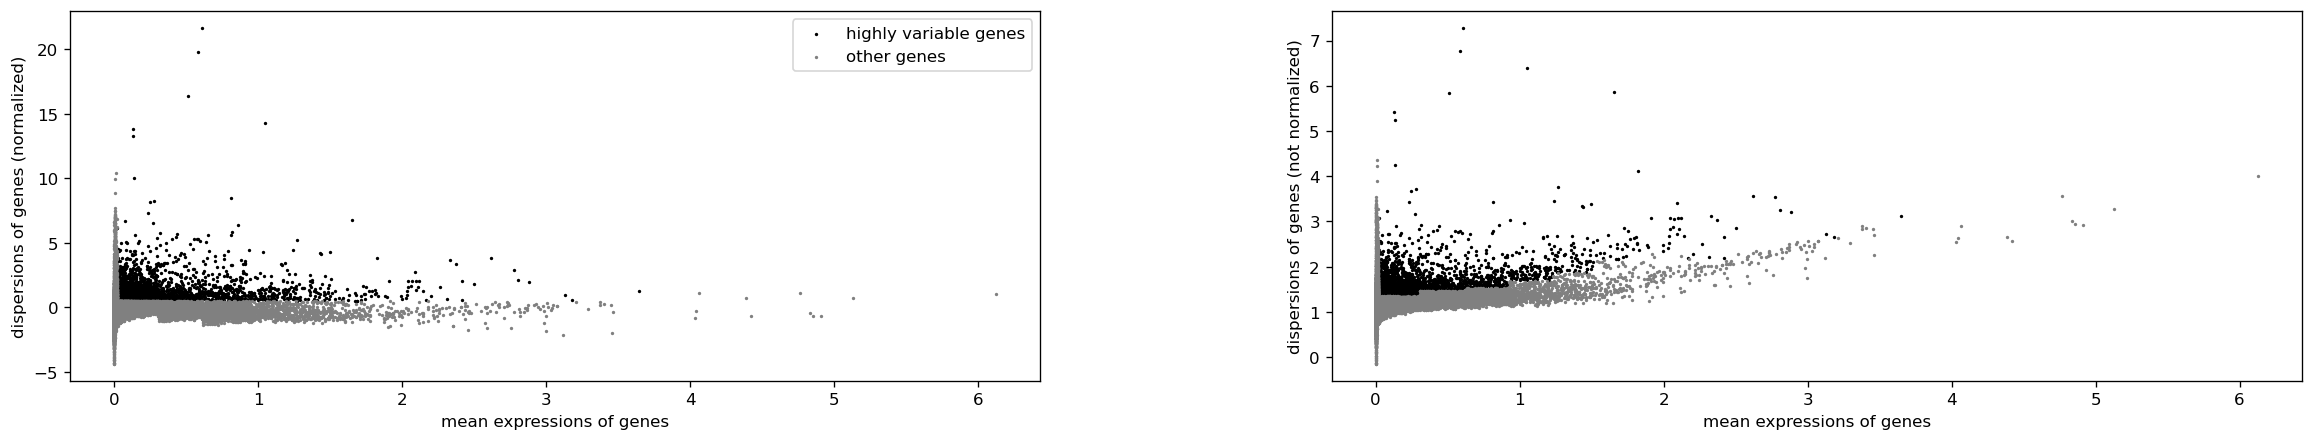

In [25]:
#adata.layers["counts"] = adata.X.copy()

#adata_pp = adata.copy()
#sc.pp.normalize_total(adata_pp)
#adata_pp.layers["norm"] = adata_pp.X.copy()
#sc.pp.log1p(adata_pp)
#sc.pp.highly_variable_genes(adata_pp, n_top_genes=2000)
#sc.pl.highly_variable_genes(adata_pp)
sc.pp.highly_variable_genes(rna, min_mean=0.02, max_mean=4, min_disp=0.5)
sc.pl.highly_variable_genes(rna)


In [26]:
rna.raw = rna
sc.pp.scale(rna, max_value=10)

/mnt/sds-hd/sd25j001/miniconda3/envs/scRNAseq_env/lib/python3.14/functools.py:982: UserWarning: zero-centering a sparse array/matrix densifies it.
  return dispatch(args[0].__class__)(*args, **kw)


In [27]:
sc.tl.pca(rna, svd_solver='arpack')

To visualise the result, we will use some markers for (large-scale) cell populations we expect to see such as T cells and NK cells (CD2), B cells (CD79A), and KLF4 (monocytes).

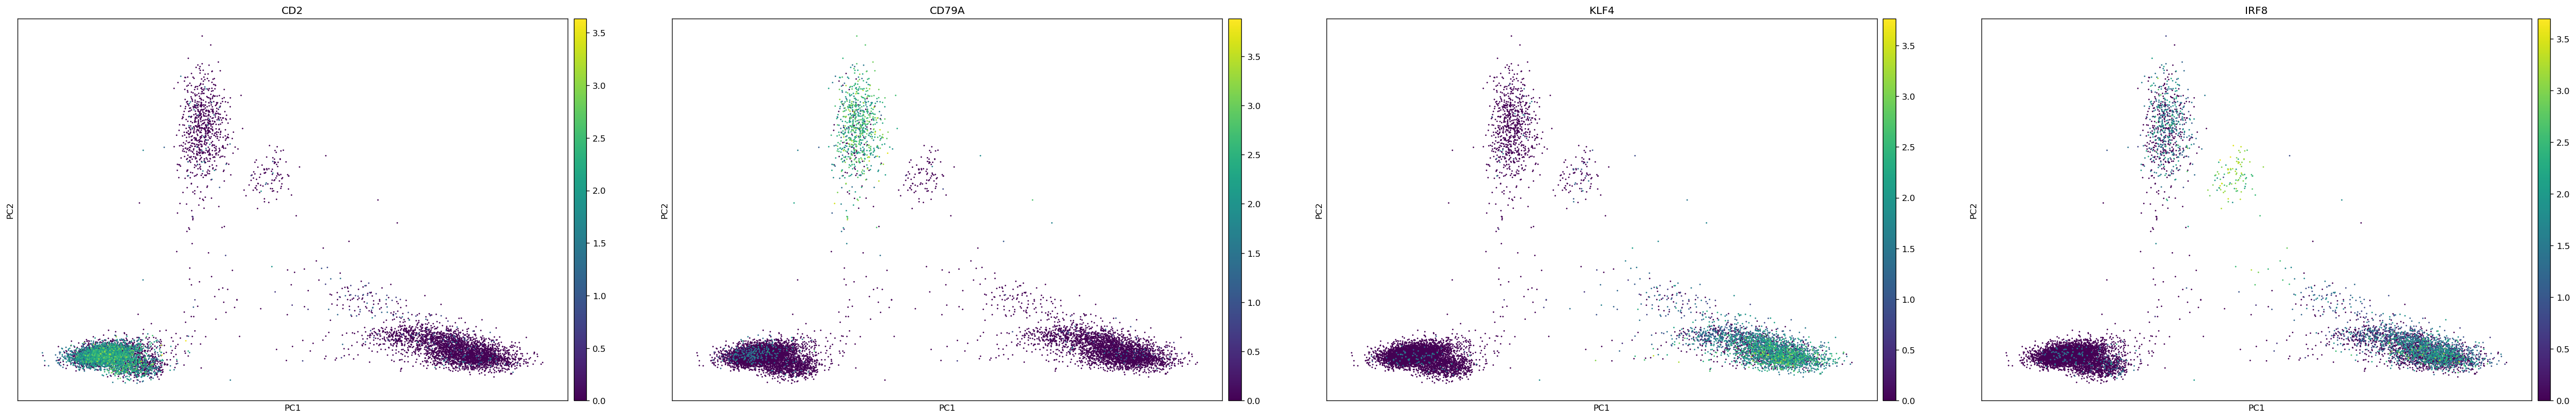

In [28]:
plt.rcParams["figure.figsize"] = (12, 8)   # width, height in inches
plt.rcParams["figure.dpi"] = 120
sc.pl.pca(rna, color=['CD2', 'CD79A', 'KLF4', 'IRF8'])


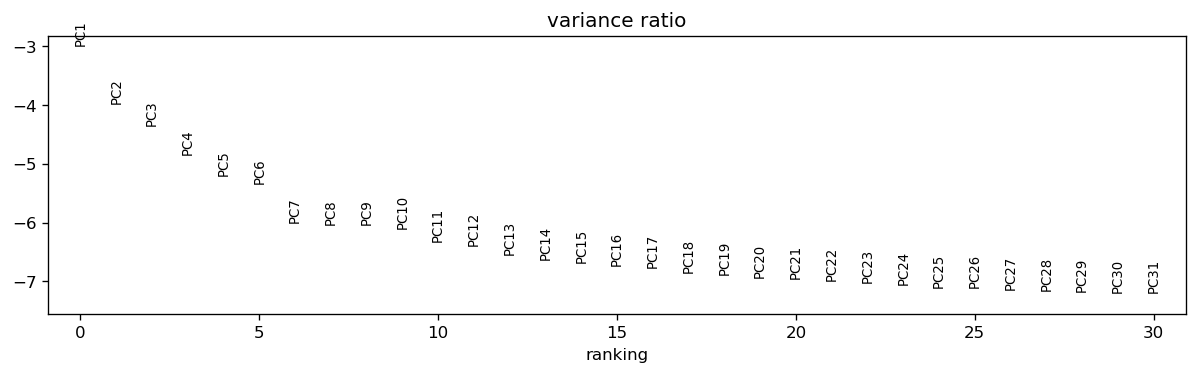

In [29]:
plt.rcParams["figure.figsize"] = (12, 3)   # width, height in inches
plt.rcParams["figure.dpi"] = 120
sc.pl.pca_variance_ratio(rna, log=True)


Non-linear dimensionality reduction and clustering
With the neighbourhood graph computed, we can now perform clustering. We will use leiden clustering as an example

In [30]:
sc.pp.neighbors(rna, n_neighbors=10, n_pcs=20) #builds a k-nearest-neighbor (kNN) graph of cells based on their gene-expression similarity. That graph is the backbone for clustering, UMAP, and many downstream analyses in Scanpy.

In [31]:
plt.rcParams["figure.figsize"] = (12, 12)   # width, height in inches
plt.rcParams["figure.dpi"] = 120
sc.tl.leiden(rna, resolution=.5)
sc.tl.umap(rna, spread=1., min_dist=.5, random_state=11) #dimentionality reduction

/tmp/ipykernel_1133497/1175299179.py:3: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(rna, resolution=.5)


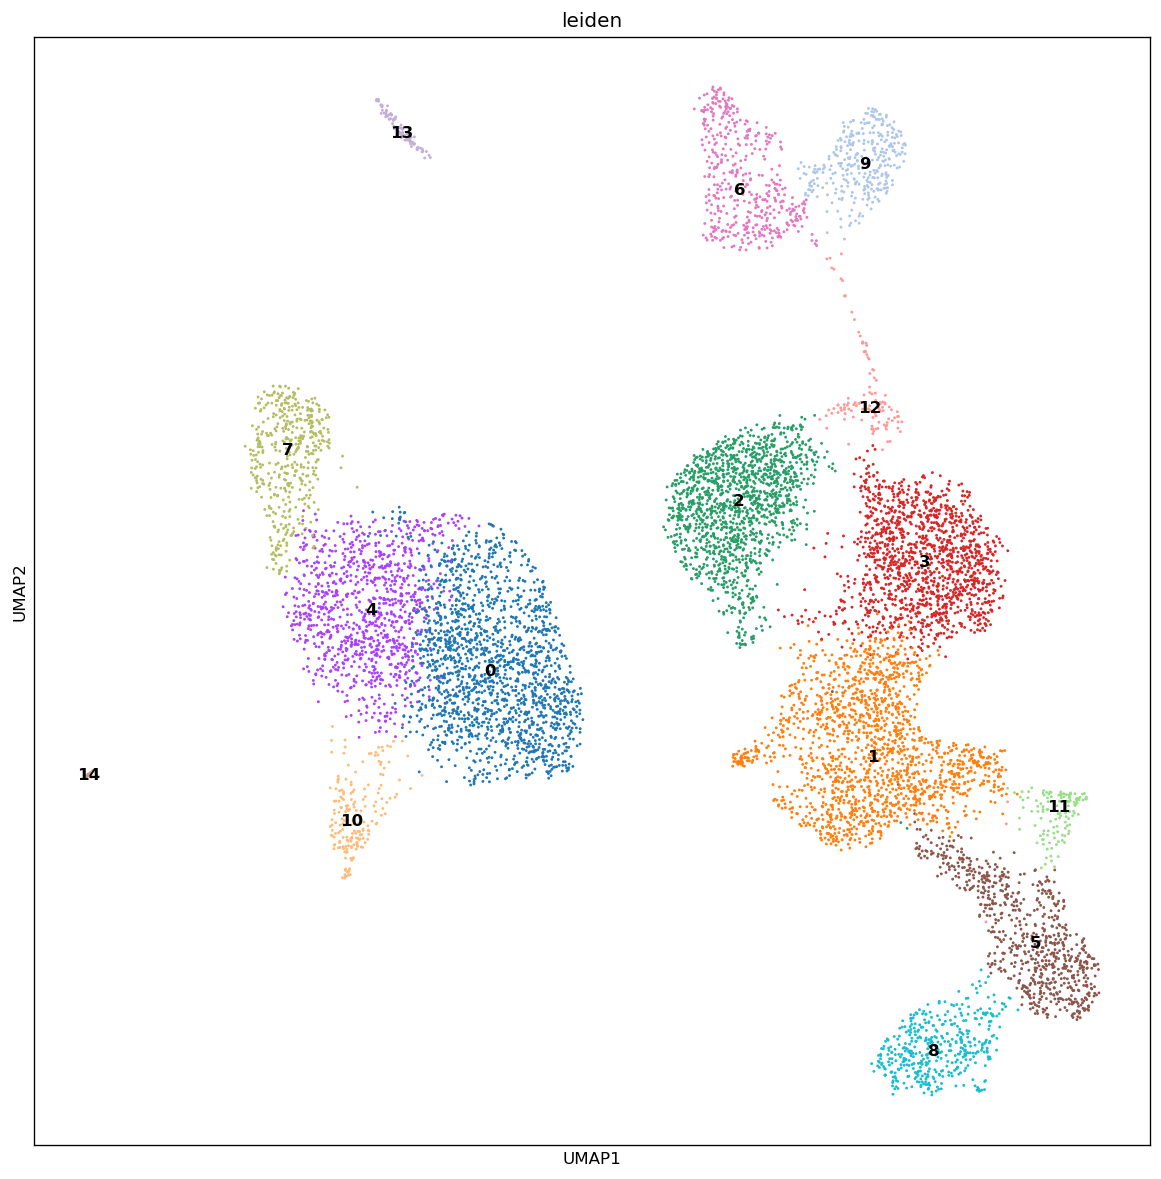

In [32]:
sc.pl.umap(rna, color="leiden", legend_loc="on data")


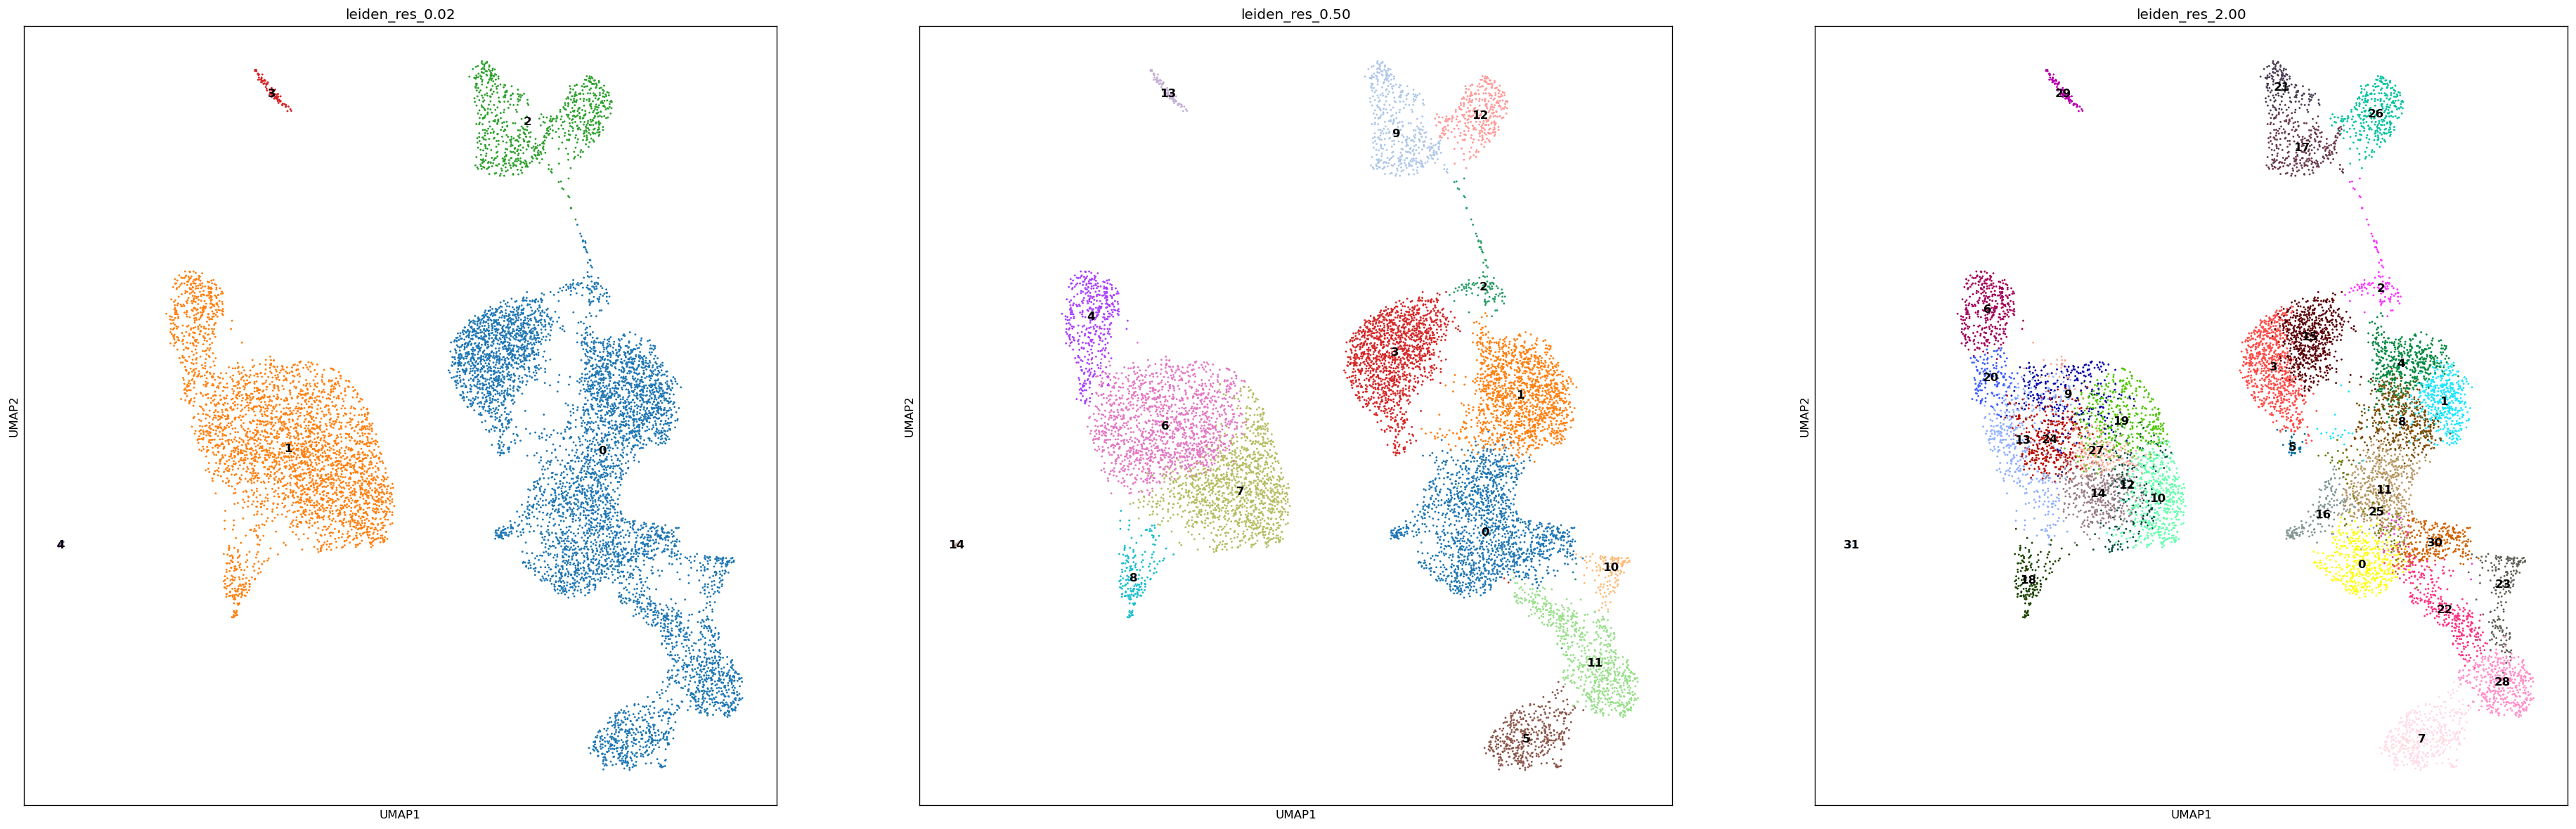

In [33]:
for res in [0.02, 0.5, 2.0]:
    sc.tl.leiden(rna, key_added=f"leiden_res_{res:4.2f}", resolution=res, flavor="igraph")
sc.pl.umap(
    rna,
    color=["leiden_res_0.02", "leiden_res_0.50", "leiden_res_2.00"],
    legend_loc="on data",
)

In [34]:
marker_genes = {
    "CD14+ Mono": ["FCN1", "CD14"],
    "CD16+ Mono": ["TCF7L2", "FCGR3A", "LYN"],
    # Note: DMXL2 should be negative
    "cDC2": ["CST3", "COTL1", "LYZ", "DMXL2", "CLEC10A", "FCER1A"],
    "Erythroblast": ["MKI67"],
    # Note HBM and GYPA are negative markers
    "Proerythroblast": ["CDK6", "SYNGR1"],
    "NK": ["GNLY", "NKG7", "CD247", "FCER1G", "TYROBP", "KLRG1", "FCGR3A"],
    "ILC": ["ID2", "PLCG2", "GNLY", "SYNE1"],
    "Naive CD20+ B": ["MS4A1", "IL4R", "IGHD", "FCRL1", "IGHM"],
    # Note IGHD and IGHM are negative markers
    "B cells": [
        "MS4A1",
        "ITGB1",
        "COL4A4",
        "PRDM1",
        "IRF4",
        "PAX5",
        "BCL11A",
        "BLK",
        "IGHD",
        "IGHM",
    ],
    "Plasma cells": ["MZB1", "HSP90B1", "FNDC3B", "PRDM1", "IGKC", "JCHAIN"],
    # Note PAX5 is a negative marker
    "Plasmablast": ["XBP1", "PRDM1", "PAX5"],
    "CD4+ T": ["CD4", "IL7R", "TRBC2"],
    "CD8+ T": ["CD8A", "CD8B", "GZMK", "GZMA", "CCL5", "GZMB", "GZMH", "GZMA"],
    "T naive": ["LEF1", "CCR7", "TCF7"],
    "pDC": ["GZMB", "IL3RA", "COBLL1", "TCF4"],
}

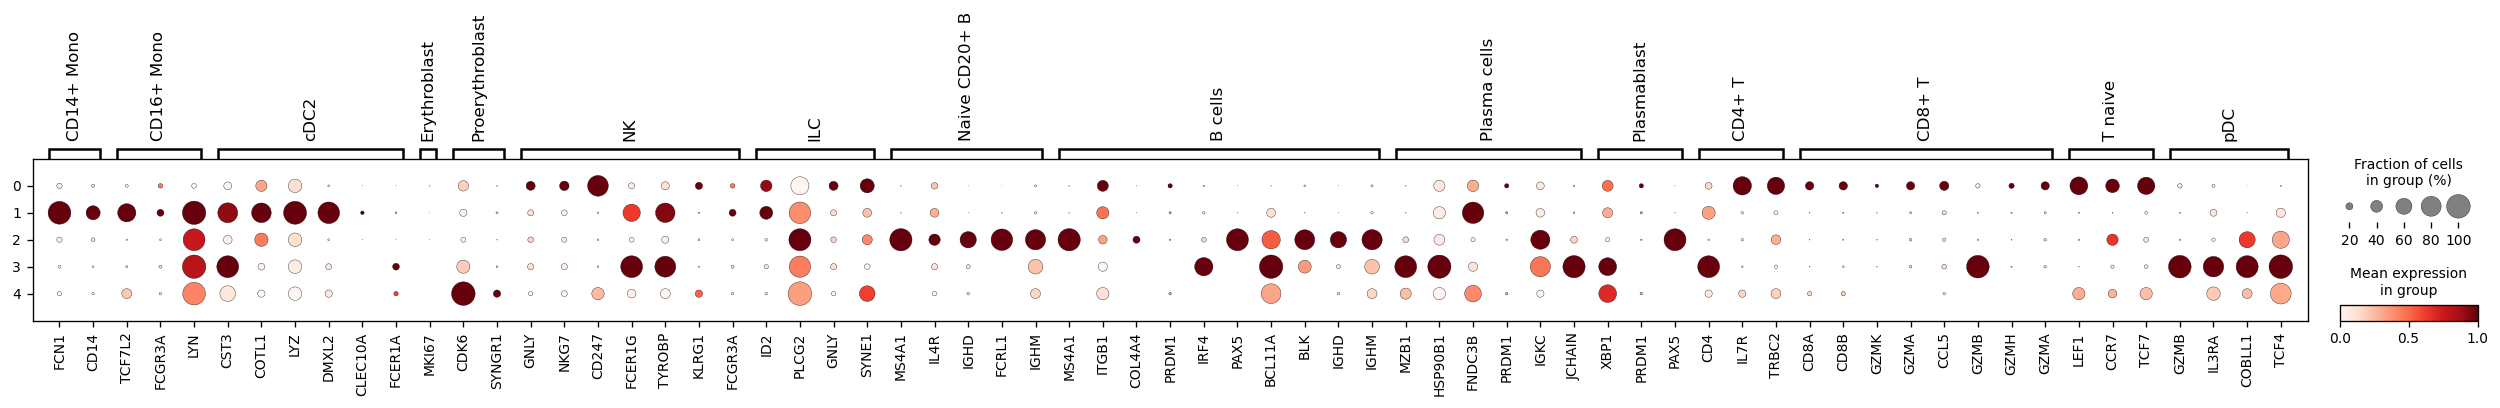

In [35]:
sc.pl.dotplot(rna, marker_genes, groupby="leiden_res_0.02", standard_scale="var")

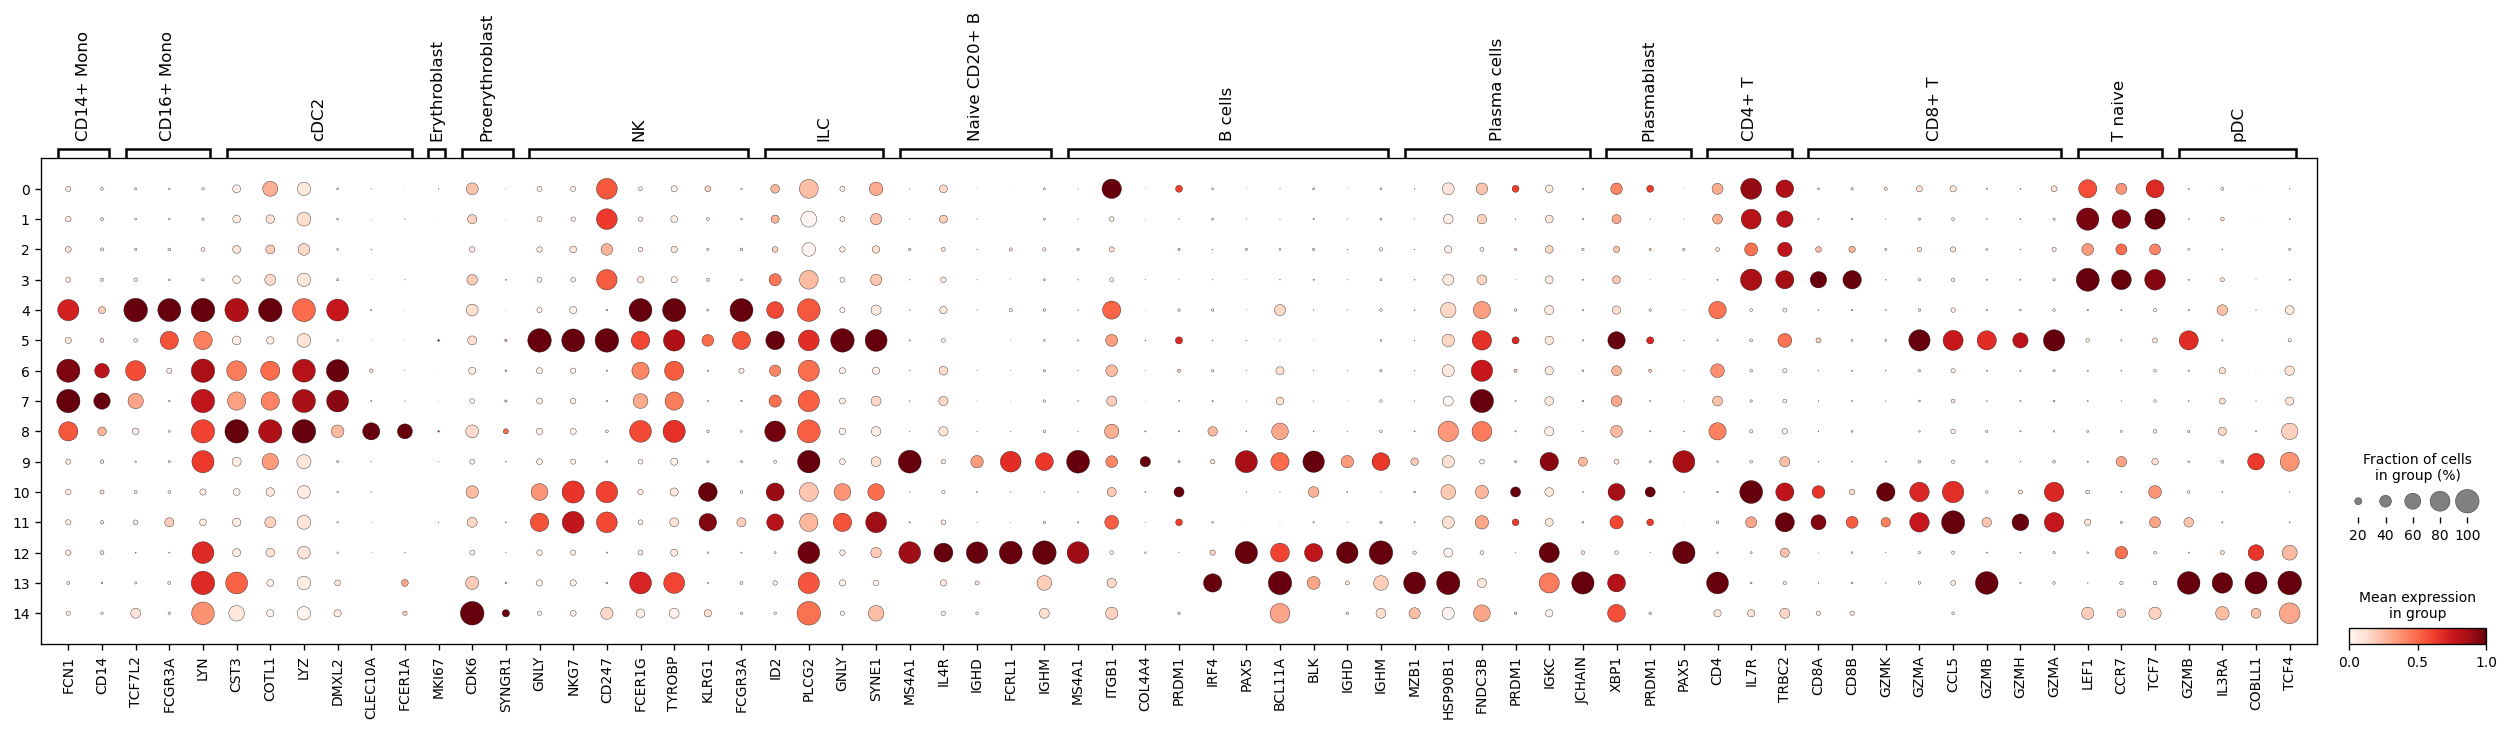

In [36]:
sc.pl.dotplot(rna, marker_genes, groupby="leiden_res_0.50", standard_scale="var")

In [42]:
rna.obs["cell_type_lvl1"] = rna.obs["leiden_res_0.02"].map(
    {
        "0": "Lymphocytes",
        "1": "Monocytes",
        "2": "Erythroid",
        "3": "B Cells",
        "4": "Unknown",
    }
)

In [43]:
rna.obs["cell_type_lvl1"]

AAACAGCCAATCCCTT-1    Lymphocytes
AAACAGCCAATGCGCT-1    Lymphocytes
AAACAGCCACACTAAT-1    Lymphocytes
AAACAGCCACCAACCG-1    Lymphocytes
AAACAGCCAGGATAAC-1    Lymphocytes
                         ...     
TTTGTTGGTGACATGC-1    Lymphocytes
TTTGTTGGTGTTAAAC-1    Lymphocytes
TTTGTTGGTTAGGATT-1    Lymphocytes
TTTGTTGGTTGCAGTA-1    Lymphocytes
TTTGTTGGTTGGTTAG-1    Lymphocytes
Name: cell_type_lvl1, Length: 10138, dtype: category
Categories (5, object): ['Lymphocytes', 'Monocytes', 'Erythroid', 'B Cells', 'Unknown']

In [44]:
agg=sc.get.aggregate(rna, by=["cell_type_lvl1"], func="sum", layer="counts")

In [45]:
df = pd.DataFrame(
    agg.layers["sum"],
    index=agg.obs_names,   # row labels (clusters)
    columns=agg.var_names, # column labels (genes)
)

In [46]:
df#.to_csv("aggregated_counts_leiden_0.50.csv")

AL627309.1  AL627309.5  AL627309.4  AL669831.2  LINC01409  \
Lymphocytes        15.0        46.0         4.0         4.0      278.0   
Monocytes          57.0       417.0        41.0         5.0      239.0   
Erythroid           0.0        10.0         0.0         2.0       49.0   
B Cells             2.0         3.0         0.0         0.0        9.0   
Unknown             0.0         0.0         0.0         0.0        1.0   

             FAM87B  LINC01128  LINC00115  FAM41C  AL645608.6  ...  \
Lymphocytes     3.0      286.0       41.0    26.0         2.0  ...   
Monocytes      12.0      178.0       91.0    27.0        11.0  ...   
Erythroid       1.0       31.0        5.0     5.0         0.0  ...   
B Cells         2.0        6.0        0.0     1.0         0.0  ...   
Unknown         0.0        4.0        0.0     0.0         0.0  ...   

             BX004987.1  AC145212.1  MAFIP  AC011043.1  AL354822.1  \
Lymphocytes         1.0         4.0   34.0         7.0        14.0   
Monocytes           2.0         2.0   22.0         3.0         6.0   
Erythroid           1.0         3.0    3.0         0.0         1.0   
B Cells             0.0         1.0    0.0         1.0         1.0   
Unknown             0.0         0.0    0.0         2.0         0.0   

             AL592183.1  AC240274.1  AC004556.3  AC007325.1  AC007325.4  
Lymphocytes      1252.0       106.0       183.0         1.0        25.0  
Monocytes         542.0       110.0       100.0         3.0        19.0  
Erythroid         196.0        26.0        25.0         0.0         1.0  
B Cells            19.0         1.0         3.0         0.0         1.0  
Unknown            11.0         0.0         1.0         0.0         0.0  

[5 rows x 26341 columns]

In [48]:
mdata

MuData object with n_obs × n_vars = 11898 × 180488
  var:	'gene_ids', 'feature_types'
  2 modalities
    rna:	11565 x 26341
      obs:	'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'doublet_score', 'doublet'
      var:	'gene_ids', 'feature_types', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
      layers:	'counts'
    atac:	11898 x 143887
      var:	'gene_ids', 'feature_types'

In [49]:
atac = mdata.mod['atac']


# Preprocessing
To filter and to normalise the data, we are going to use the same scanpy functionality as we use when working with gene expression. The only thing to bear in mind here that a gene would mean a peak in the context of the AnnData object with ATAC-seq data.

# QC
Perform some quality control filtering out cells with too few peaks and peaks detected in too few cells. For now, we will filter out cells that do not pass QC.

In [50]:
sc.pp.calculate_qc_metrics(atac, percent_top=None, log1p=False, inplace=True)


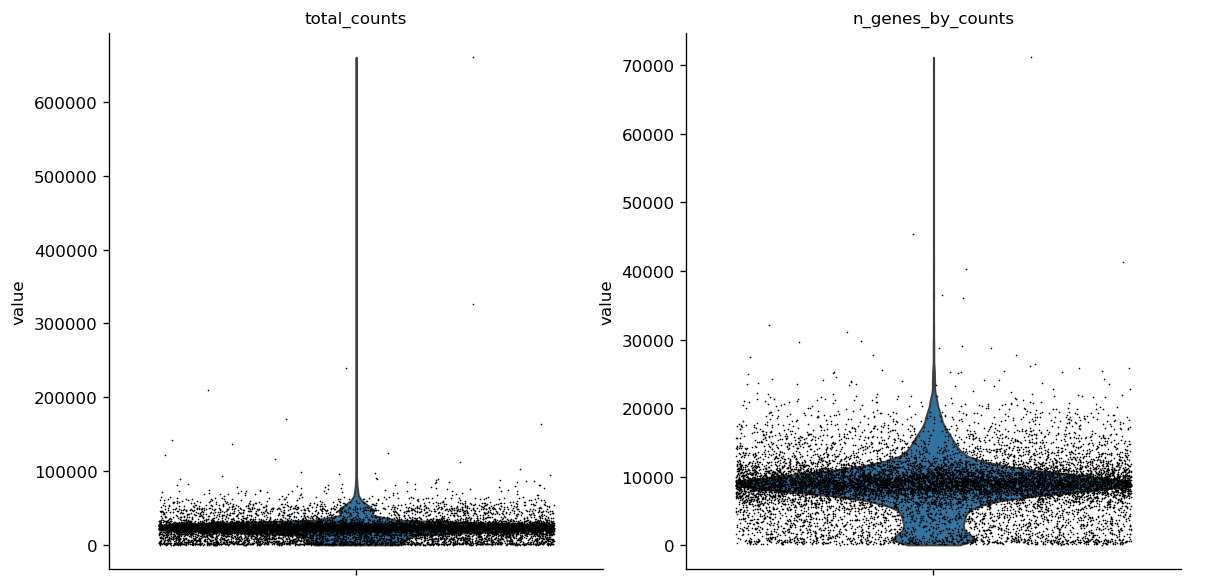

In [51]:
sc.pl.violin(atac, ['total_counts', 'n_genes_by_counts'], jitter=0.4, multi_panel=True)


Filter peaks which expression is not detected:

In [52]:
mu.pp.filter_var(atac, 'n_cells_by_counts', lambda x: x >= 10)
# This is analogous to
#   sc.pp.filter_genes(rna, min_cells=10)
# but does in-place filtering and avoids copying the object

In [53]:
mu.pp.filter_obs(atac, 'n_genes_by_counts', lambda x: (x >= 2000) & (x <= 15000))
# This is analogous to
#   sc.pp.filter_cells(atac, max_genes=15000)
#   sc.pp.filter_cells(atac, min_genes=2000)
# but does in-place filtering avoiding copying the object

mu.pp.filter_obs(atac, 'total_counts', lambda x: (x >= 4000) & (x <= 40000))

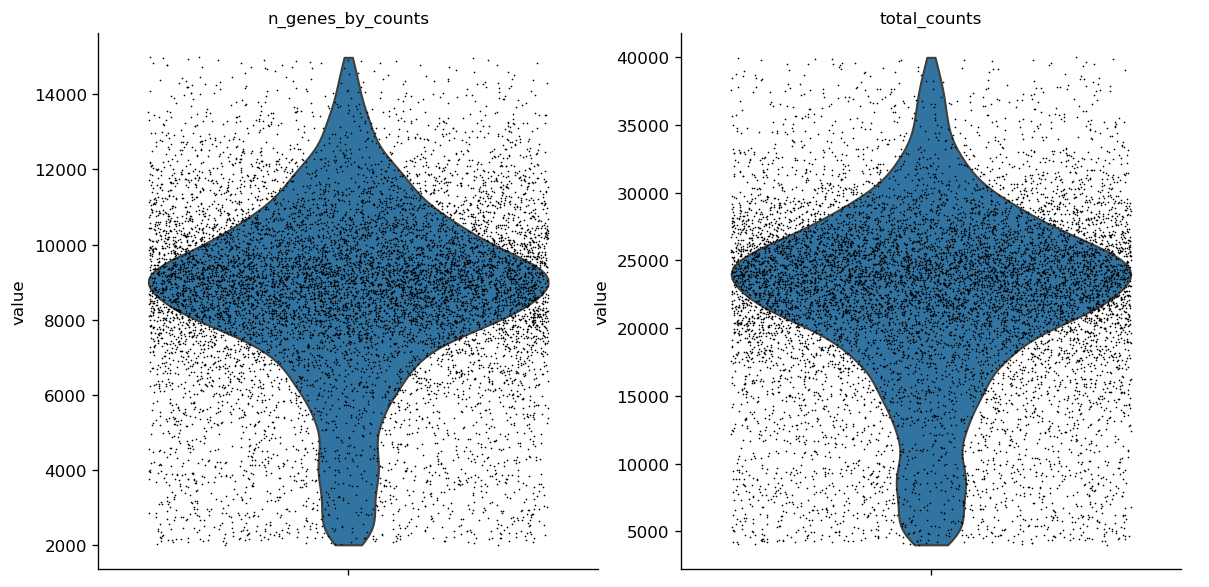

In [54]:
sc.pl.violin(atac, ['n_genes_by_counts', 'total_counts'], jitter=0.4, multi_panel=True)
